In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
import sklearn
%load_ext autoreload
import scipy

# Funções Base

In [2]:
#find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

def find_index(wavelenghts,w):
    return np.argmin(np.abs(wavelenghts - w))

In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [4]:
def read_data_map(file):
    hf = h5py.File(file, 'r')
    spectrums = np.array(hf.get('intensities'))
    positions = np.array(hf.get('position'))
    wavelengths = np.array(hf.get('wavelengths'))
    positions = np.delete(positions, 0, 0)
    spectrums = np.delete(spectrums, 0, 0)
    x = positions[:, 0]
    y = positions[:, 1]
    xy = np.lexsort((y, x))

    hf.close()
    return spectrums[xy], wavelengths, positions

In [5]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [6]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

In [7]:
def entropy_calc(map_gr):
    import cv2
    from scipy.stats import entropy

    #image

    _bins = 200

    hist, _ = np.histogram(map_gr, bins=_bins, range=(0, _bins))

    prob_dist = hist / hist.sum()
    image_entropy = entropy(prob_dist, base=2)
    return image_entropy

# Ideia Inicial: Clustering com 2 kmeans - Raman: Minibife

## Dados e pre-processamento

In [8]:
filename = "20231129_ 952.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

lam = 1e2
p = 1e-1

pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        if sum_spec!=0:
            pro_data_norm[i,j,:]=spec/sum_spec
        else: 
            pro_data_norm[i,j,:]=0
offset_l = 31
offset_m = 328

mask = pro_data_norm[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)

100%|██████████| 120/120 [01:54<00:00,  1.05it/s]


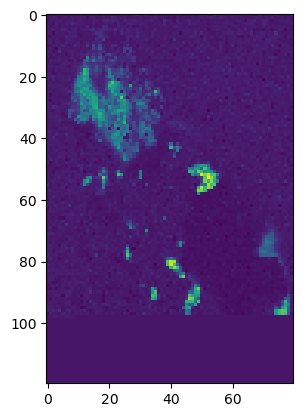

In [10]:
plt.figure()
plt.imshow(pro_data_norm[:,:,find_index(wavelengths_raman,509)])

## Threshold para minimizar o ruido

In [8]:
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])

## Clustering binário: ruido/informação

In [9]:
init_k=[0,1]
mask_min_max = np.array([(mask_t[i, :] - mask_t[i, :].min(axis = 0)+ 1e-5)/(mask_t[i, :].max(axis = 0) - mask_t[i, :].min(axis = 0) + 1e-5) for i in range(mask_t.shape[0])])
masks = np.array([sklearn.cluster.KMeans(n_clusters = 2, random_state = 100).fit_predict(mask_min_max[i, :].reshape(-1, 1)) for i in tqdm(range(mask_min_max.shape[0]))])

  0%|          | 0/297 [00:00<?, ?it/s]c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  0%|          | 1/297 [00:00<03:06,  1.59it/s]c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  1%|          | 2/297 [00:01<02:54,  1.69it/s]c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  1%|          | 3/297 [00:01<02:50,  1.73it/s]c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `

Albite
Background
Background not found
Quartz
Muscovite
Lepidolite


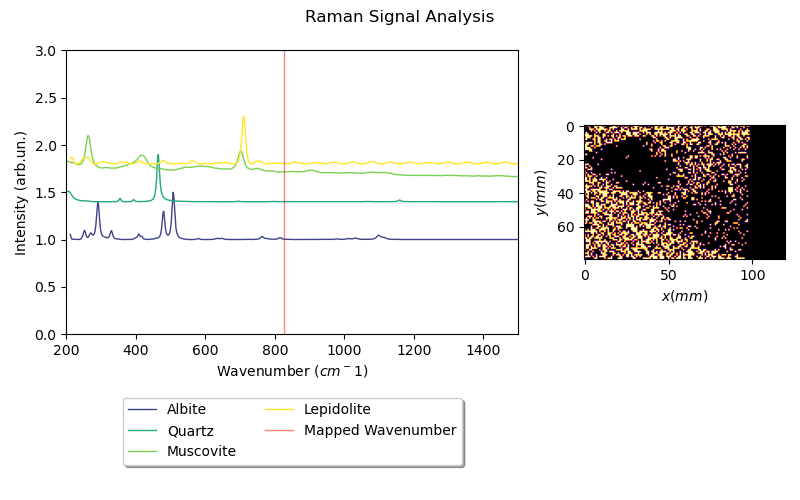

C:\Users\Joana\AppData\Local\Temp\ipykernel_16424\651272957.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])
C:\Users\Joana\AppData\Local\Temp\ipykernel_16424\651272957.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])


In [12]:
%matplotlib widget
fig, ax = subplots(1, 2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    #'Petalite':[491.3],
    'Quartz':[463.92],
    #'Spodumene':[704.5]
    'Muscovite':[986],
    'Lepidolite':[707] 
    
}


mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        axs.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec), lw = 1, color = cm.viridis((i+1)/len(mineral_list)), label = mineral)
    except:
        print(mineral + ' not found')
axs.set_ylim(0,1+0.2*(i+1)+1)
axs.set_xlim(200,1500)
    
axs.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.0), ncol = 2, fancybox = True, shadow = True)
wn = 120
line = axs.axvline(wavelengths_raman[offset_l:offset_m][wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavenumber')
axs.set_xlabel(r'Wavenumber $(cm^-1)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(loc='upper center', bbox_to_anchor = (0.5, -0.2), ncol = 2, fancybox = True, shadow = True)

axs = ax[1]
axs.imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno,
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

## Clustering Final

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


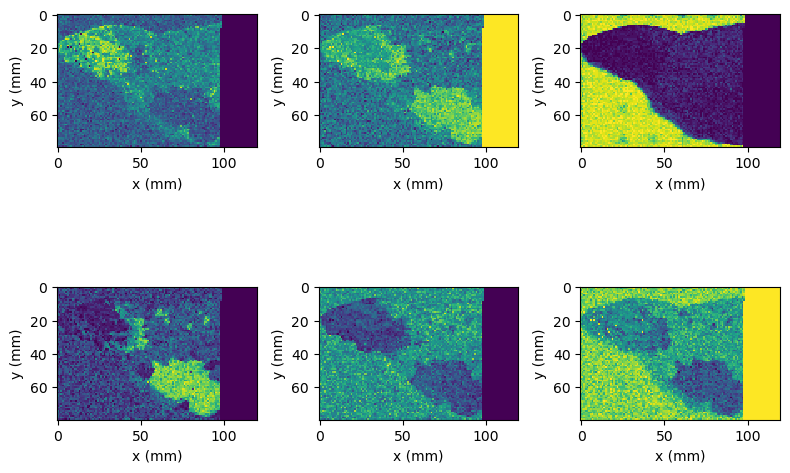

In [16]:
%matplotlib inline
kmeans = sklearn.cluster.KMeans(n_clusters = 6)
a=kmeans.fit_predict(masks)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (8, 6))
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

# 2. Usar a Entropia para feature extraction: Minibife

In [18]:
mask_min_max=scipy.ndimage.gaussian_filter(mask_min_max,sigma=0.5) #filtro gaussiano
entropy_masks=np.array([mask_min_max[i,:]*255 for i in range(297)]) #passar a 255 para calcular entropia

offset_l = 31
offset_m = 328
wavelengths_raman.shape
wavelengths=wavelengths_raman[offset_l:offset_m]

#escolher os comprimentos de onda que correspondem a features
minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Quartz':[463.92],
    'Muscovite':[986],
    'Lepidolite':[707] 
    
}

mineral_list = list(minerals.keys())

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))

significant_w=[]
for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    significant_w.append(wn)

#calculo da entropia
image_entropy=[]
for i in range(297):
    map_gr=entropy_masks[i]
    image_entropy.append(entropy_calc(map_gr))


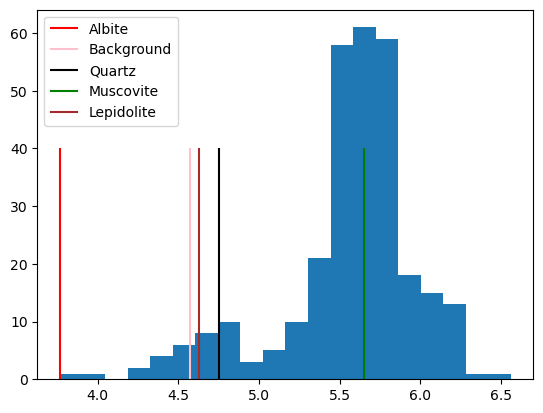

In [19]:
plt.hist(image_entropy,bins=20)
colors=['red','pink','black','green','brown']
for i in range(len(significant_w)):
    plt.vlines(image_entropy[significant_w[i]],0,40,color=colors[i],label=mineral_list[i])
    
plt.legend()

## escolher mapas com entropias entre as dos mapas das features

In [20]:
relevant_entropies=[]
for i in significant_w:
    relevant_entropies.append(image_entropy[i])
    
max_en=np.max(relevant_entropies)
min_en=np.min(relevant_entropies)

new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if min_en<=image_entropy[i]<=max_en:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)

## Unsupervised Clustering só com esses mapas

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


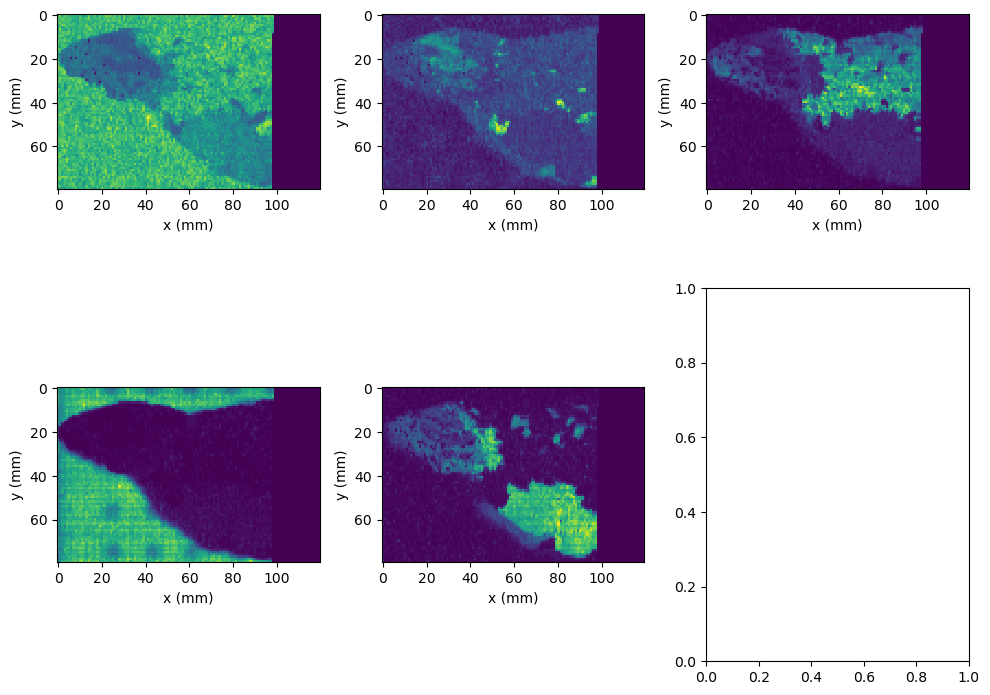

In [21]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5)
a=kmeans.fit_predict(new_maps_cut)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

Também tinha testado algortimos para equalização da entropia em todos os mapas, que são usados para melhorar a classificação de imagens, mas não melhoravam os resultados.

# 3. Entropia como feature extraction: Amostra mais usada

In [22]:
filename = "2023913_1110.h5"
#filename = "2023811_1451.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

lam = 1e2
p = 1e-1
    
pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec
offset_l = 31
offset_m = 328

mask = pro_data_norm[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)

threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])

mask_min_max = np.array([(mask_t[i, :] - mask_t[:, :].min()+ 1e-5)/(mask_t[:, :].max() - mask_t[:, :].min() + 1e-5) for i in range(mask_t.shape[0])])

entropy_masks=mask_min_max*255

offset_l = 31
offset_m = 328
wavelengths_raman.shape
wavelengths=wavelengths_raman[offset_l:offset_m]

minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))

significant_w=[]
for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    significant_w.append(wn)

image_entropy=[]
for i in range(297):
    map_gr=entropy_masks[i]
    image_entropy.append(entropy_calc(map_gr))


100%|██████████| 250/250 [06:03<00:00,  1.46s/it]


## Entropias

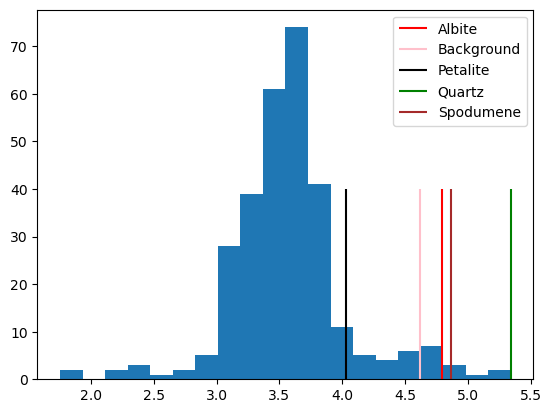

In [23]:
plt.hist(image_entropy,bins=20)
colors=['red','pink','black','green','brown']
for i in range(len(significant_w)):
    plt.vlines(image_entropy[significant_w[i]],0,40,color=colors[i],label=mineral_list[i])
    
plt.legend()

In [24]:
relevant_entropies=[]
minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())

for i in significant_w:
    relevant_entropies.append(image_entropy[i])
    
max_en=np.max(relevant_entropies)+0.2
min_en=np.min(relevant_entropies)-0.2

new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if min_en<=image_entropy[i]<=max_en:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)

## Classificação

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


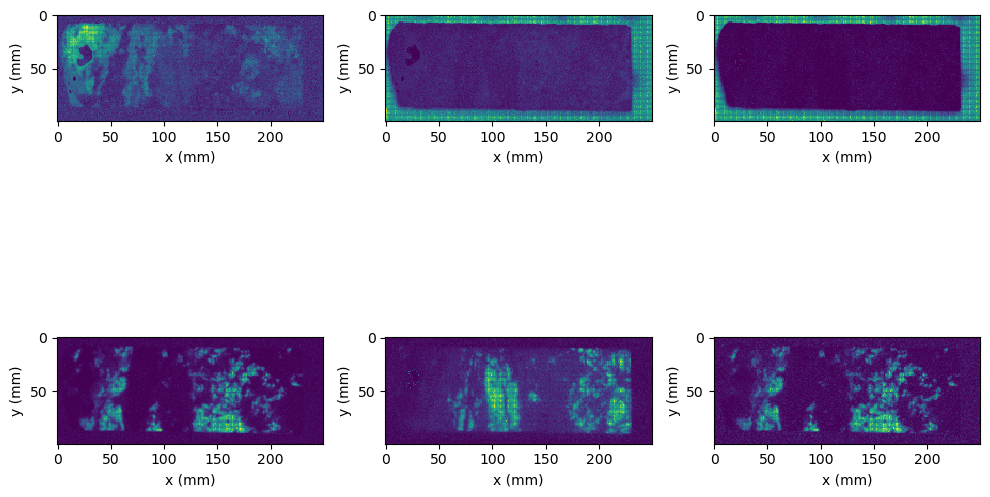

In [25]:
kmeans = sklearn.cluster.KMeans(n_clusters = 6,random_state=0)
a=kmeans.fit_predict(new_maps_cut)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

Testei várias formas de inicialização com padrões tipo xadrez e também aplicar um filtro gaussiano, para tentar que um dos clusters fosse a petalite mas nenhuma das hipóteses funcionou

## Aplicar Thresholds antes da classificação

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


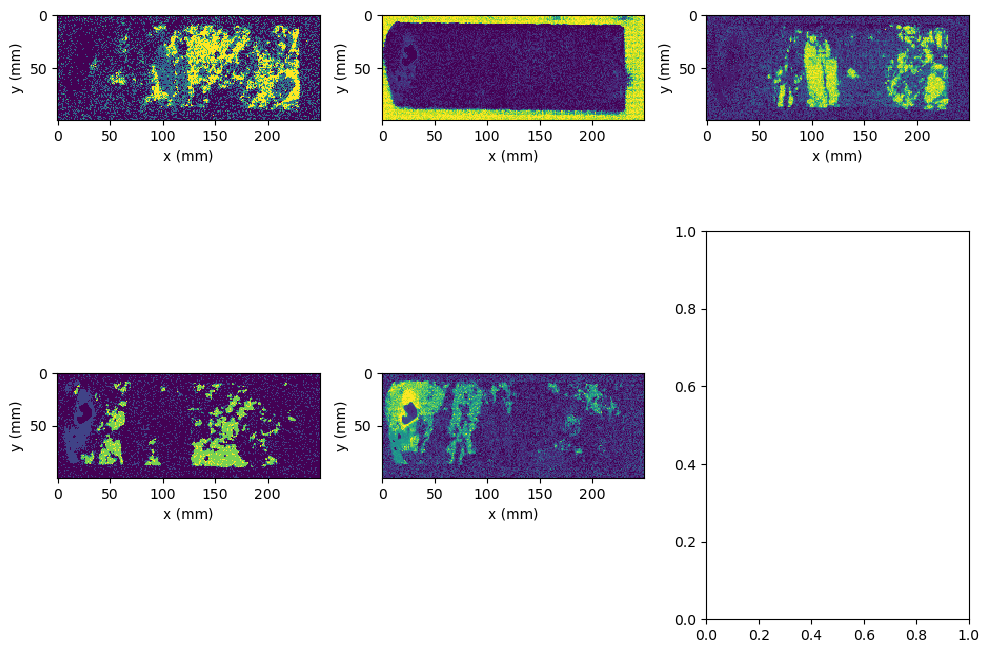

In [26]:
from skimage.filters import threshold_otsu
import cv2
thresholds=np.array([threshold_otsu(new_maps_cut[i]) for i in range(new_maps_cut.shape[0])])

maps_thres=[]
for i in range(new_maps_cut.shape[0]):
    c_mask=np.zeros(new_maps_cut.shape[1])
    for j in range(new_maps_cut.shape[1]):
        if new_maps_cut[i][j]>thresholds[i]:
            c_mask[j]=1
    maps_thres.append(c_mask)
maps_thres=np.array(maps_thres)  

kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
a=kmeans.fit_predict(maps_thres)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

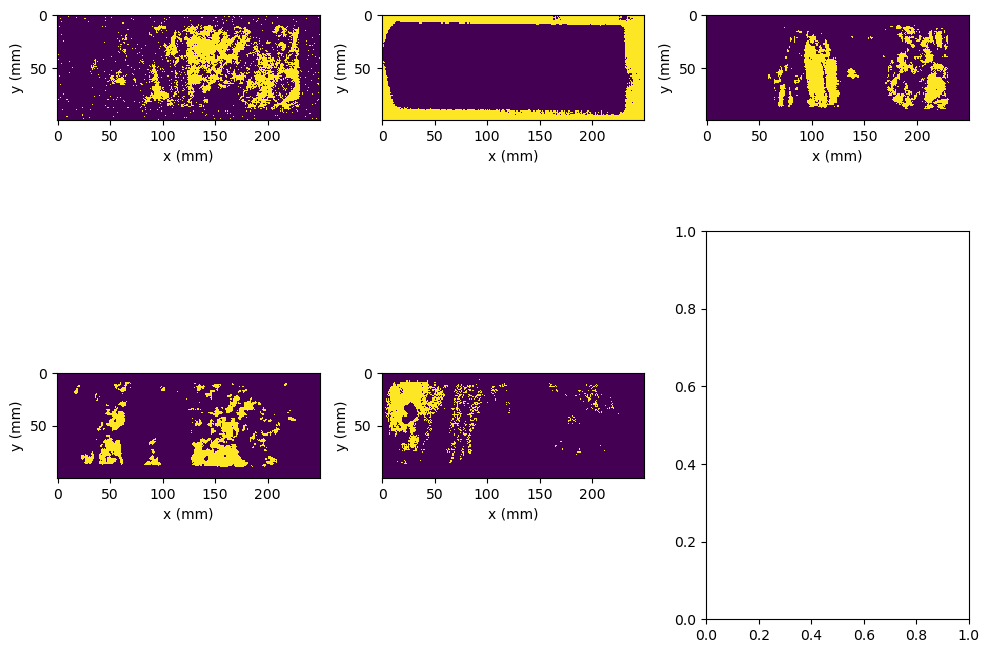

In [27]:
clusters_c = np.array(kmeans.cluster_centers_)
for i in range(clusters_c.shape[0]):
    for j in range(clusters_c.shape[1]):
        if clusters_c[i][j]<0.6:
            clusters_c[i][j]=0
        else:
            clusters_c[i][j]=1

fig, ax = subplots(2, 3, figsize = (10, 8))

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

### Resultado: União dos mapas encontrados pelo clustering

Área de cobertura 76.0 %


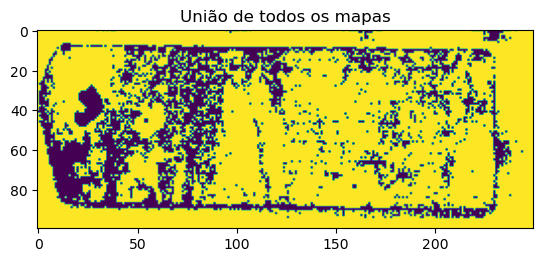

In [28]:
img_or = clusters_c[0]

for img in clusters_c[1:]:
    img_or = cv2.bitwise_or(img_or, img)
    
imshow(img_or.reshape(250,100).T)
plt.title('União de todos os mapas')
cut_int=img_or.copy()
print('Área de cobertura',round(sum(cut_int)/(cut_int.shape[0]*cut_int.shape[1]),2)*100, '%')

### % de cada mineral

In [ ]:
fig_ar=pro_data.shape[0]*pro_data.shape[1]
areas=[]
minerals_order=['Albite','Background','Petalite','Spodumene','Quartz','']
for i in range (len(clusters_c)):
    a=np.sum(clusters_c[i])
    areas.append(a)
areas.append((fig_ar-np.sum(areas)))
fig, ax = plt.subplots()


centre_circle = plt.Circle((0, 0), color='white', edgecolor='black', linewidth=0.9)
ax.add_artist(centre_circle)

ax.pie(areas, labels=minerals_order, autopct='%1.1f%%', wedgeprops=dict(width=0.27, edgecolor='w'))
ax.axis('equal')  
plt.show()


Como estes resultados permitiram identificar um cluster de cada mineral decidimos testar a hipótese de fazer classificação por overlap com esses mapas

### Classificação por overlap

In [29]:
def intersection_maps(maps):
    img_and = maps[0]

    for img in maps[1:]:
        img_and = cv2.bitwise_and(img_and, img)
    return img_and
int_all=[]
for i in range(clusters_c.shape[0]):
    int_s=[]
    for j in range(new_maps_cut.shape[0]):
        int_s.append(sum(intersection_maps([clusters_c[i],maps_thres[j]]))/sum(clusters_c[i]))
    int_all.append(int_s)
    
int_all=np.array(int_all)

contain=np.zeros([int_all.shape[0],int_all.shape[1]])
for i in range(int_all.shape[0]):
    for j in range(int_all.shape[1]):
        if int_all[i][j]>0.6:
            contain[i][j]=1

#### Exemplo de resultado

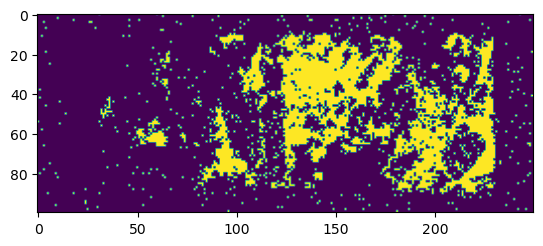

In [30]:
imshow(clusters_c[0].reshape(250,100).T)

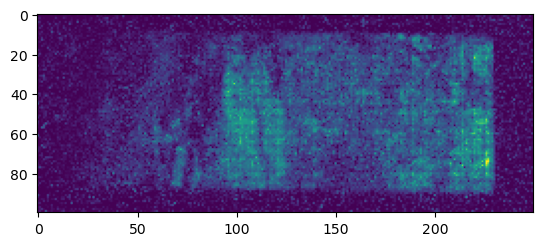

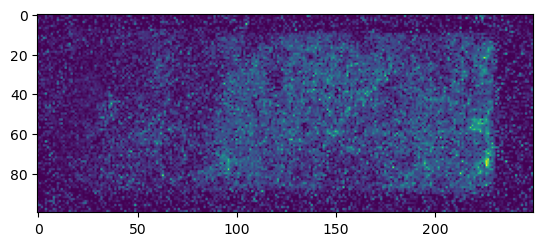

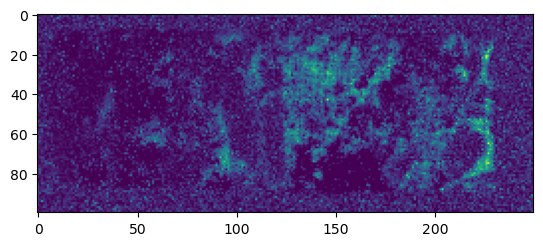

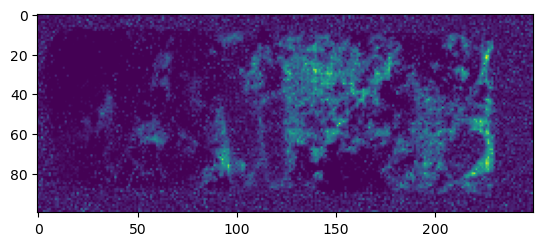

In [31]:
for i in range(contain.shape[1]):
    if contain[0][i]==1:
        imshow(new_maps_cut[i].reshape(250,100).T)
        plt.show()

#### Análise: Mapa médio de todos os mapas atribuidos a cada cluster

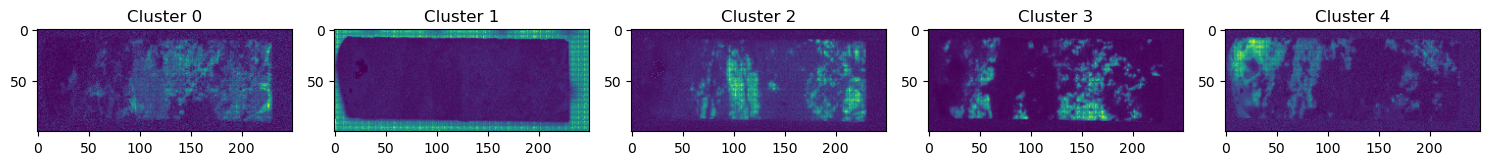

In [32]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 3))  
clusters_o=[]
for cluster_type, ax in enumerate(axes):
    maps = []
    weights = []
    
    for i in range(contain.shape[1]):
        if contain[cluster_type][i] == 1:
            maps.append(new_maps_cut[i])
            weights.append(int_all[cluster_type][i])

    norm_weights = np.array(weights) / np.sum(weights)

    cluster = np.zeros(new_maps_cut[0].shape)
    for i in range(norm_weights.shape[0]):
        cluster += norm_weights[i] * maps[i]
    
    ax.imshow(cluster.reshape(250, 100).T)
    ax.set_title(f'Cluster {cluster_type}')
    clusters_o.append(cluster)
plt.tight_layout()
plt.show()


# 4. Teste da entropia para feature extraction em dados do LIBS

100%|██████████| 16384/16384 [00:00<00:00, 49511.53it/s]


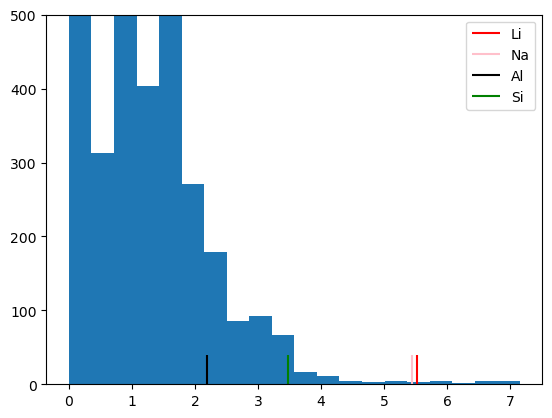

In [35]:
filename = "PetalideEspodumena_ADG-2-40-8_map"
def read_data_map(file):
 
    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]
 
    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
 
   
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
   
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
   
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y
spectrum, wavelengths, positions,unique_x,unique_y = read_data_map(filename)

pro_data = 1*spectrum

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec
mask = pro_data_norm[:, :, :].reshape(pro_data.shape[0]*pro_data.shape[1], -1)
       
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in tqdm(range(mask_offset.shape[-1]))])

maxi=mask_t.max()
mini=mask_t.min()

mask_min_max = np.array([(mask_t[i, :] - mini)/(maxi -mini) for i in tqdm(range(mask_t.shape[0]))])
entropy_masks=mask_min_max*255

offset_l = 0
offset_m = -1

minerals = {
    
    'Li':[610.22],
    'Na':[588.99],
    'Al':[309.27],
    'Si':[288.13]}


wl = [670.76, 588.99, 309.27, 288.16, 766.5]
mineral_list = list(minerals.keys())

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))

significant_w=[]
for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    significant_w.append(wn)

image_entropy=[]
for i in range(mask_t.shape[0]):
    map_gr=entropy_masks[i]
    image_entropy.append(entropy_calc(map_gr))
    
plt.hist(image_entropy,bins=20)
colors=['red','pink','black','green','brown']
for i in range(len(significant_w)):
    plt.vlines(image_entropy[significant_w[i]],0,40,color=colors[i],label=mineral_list[i])
    
plt.legend()
plt.ylim([0,500])


relevant_entropies=[]

for i in significant_w:
    relevant_entropies.append(image_entropy[i])

min_en=np.min(relevant_entropies)-0.2


new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if min_en<=image_entropy[i]:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


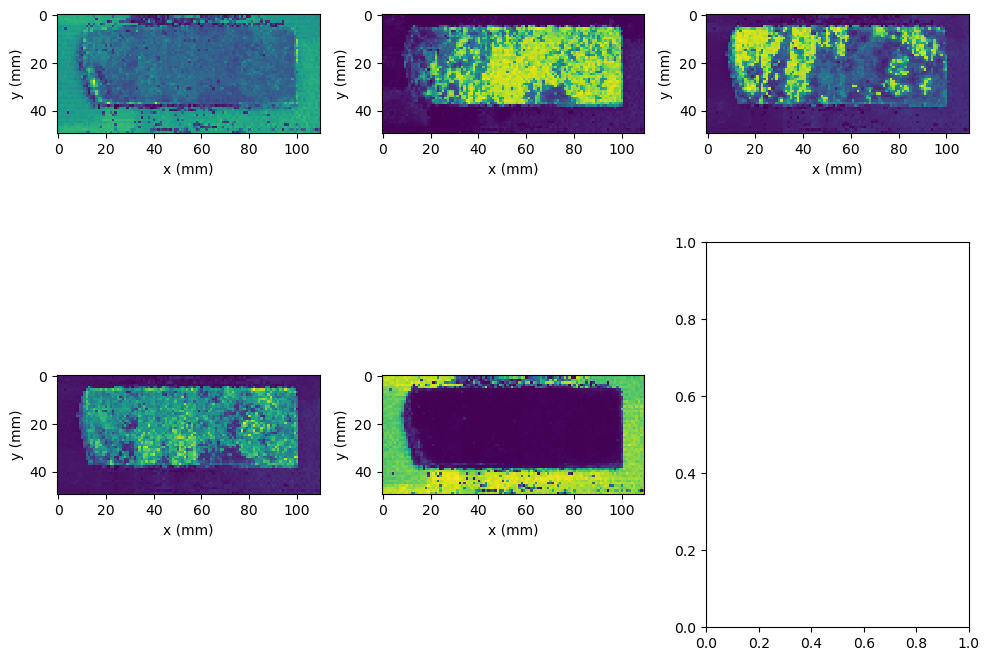

In [37]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
a=kmeans.fit_predict(new_maps_cut)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]), interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()


## Comparação com os elementos

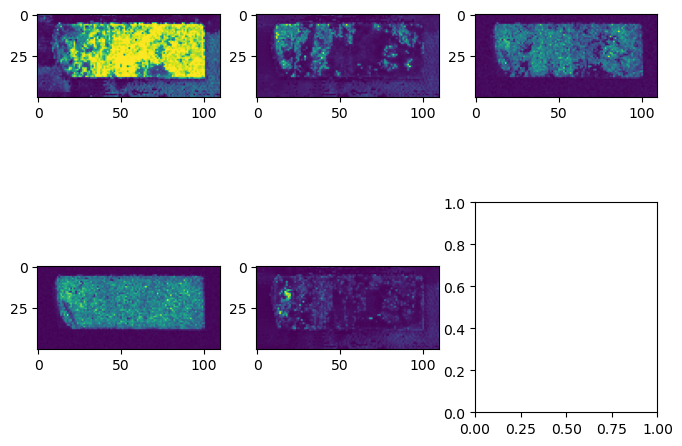

In [42]:
wl = [670.76, 588.99, 309.27, 288.16, 766.5]
fig,ax=plt.subplots(2,3,figsize=(8,6))
for i in range(3):
    ax[0,i].imshow(spectrum[:,:,find_index(wavelengths,wl[i])])

ax[1,0].imshow(spectrum[:,:,find_index(wavelengths,wl[3])])
ax[1,1].imshow(spectrum[:,:,find_index(wavelengths,wl[-1])])

# 5. Testes com algoritmo de FFT em vez de usar a entropia: Raman

In [43]:
filename = "2023913_1110.h5"
#filename = "2023811_1451.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

lam = 1e2
p = 1e-1
    
pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

pro_data_norm=pro_data.copy()

offset_l = 31
offset_m = 328

mask = pro_data_norm[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)

wavelengths=wavelengths_raman[offset_l:offset_m]

threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])

from scipy.ndimage import gaussian_filter
mask_t=gaussian_filter(mask_t,sigma=0.7)

normalized_spec1=np.transpose(mask_t.reshape(297,250,100),axes=(1,2,0))

100%|██████████| 250/250 [06:15<00:00,  1.50s/it]


## FFT

In [44]:
nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.2
dy = 0.2
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 5)

100%|██████████| 297/297 [00:00<00:00, 1212.99it/s]


In [ ]:
%matplotlib notebook
fig, ax = subplots(1,2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
axs.plot(wavelengths,sums)
axs = ax[1]
axs.imshow(normalized_spec1[:, :, wn], cmap = cm.inferno, extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                                                        0, exp_properties['step_size']*exp_properties['n_points'][0]])
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(normalized_spec1[:, :, wn], cmap = cm.inferno,
                      extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                            0, exp_properties['step_size']*exp_properties['n_points'][0]],
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

## Procurar formas "automáticas" de selecionar as bandas 

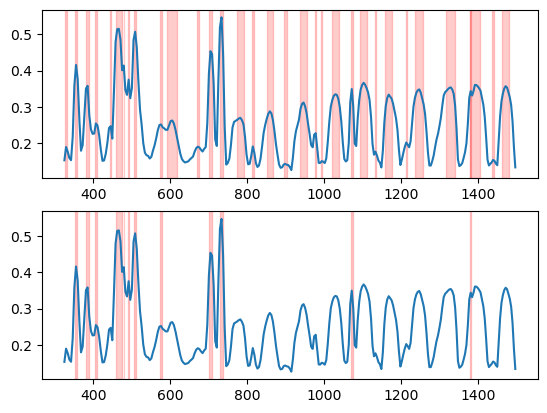

In [45]:
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])



peaks=scipy.signal.find_peaks(sums)[0]
heights=sums[peaks]
widths=scipy.signal.peak_widths(sums, peaks)[0]
fig,ax=subplots(2)
axs = ax[0]
axs.plot(wavelengths,sums)

for i in range(len(widths)):
    axs.axvspan(wavelengths[peaks[i]]-widths[i],wavelengths[peaks[i]]+widths[i], ymin=0, ymax=1, alpha=0.2,color='red')

axs=ax[1]
axs.plot(wavelengths,sums)
#print(widths)
#print(heights)
new_selected_maps=[]

il=[]
im=[]

for i in range(len(widths)):
    if widths[i]<=8.05 and heights[i]>0.25:
        axs.axvspan(wavelengths[peaks[i]]-widths[i],wavelengths[peaks[i]]+widths[i], ymin=0, ymax=1, alpha=0.2,color='red')
        il.append(find_index(wavelengths,wavelengths[peaks[i]]-widths[i]))
        im.append(find_index(wavelengths,wavelengths[peaks[i]]+widths[i]))
        
for j in range(len(il)):
    
    for k in range(il[j],im[j]+1):
        new_selected_maps.append(mask_t[k])
    

In [46]:
from scipy.ndimage import gaussian_filter
mask_t=np.array(new_selected_maps)
#mask_t=gaussian_filter(mask_t,sigma=0.7)
mask_min_max = np.array([(mask_t[i, :] - mask_t[:, :].min())/(mask_t[:, :].max() - mask_t[:, :].min()) for i in range(mask_t.shape[0])])

### Classificação

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


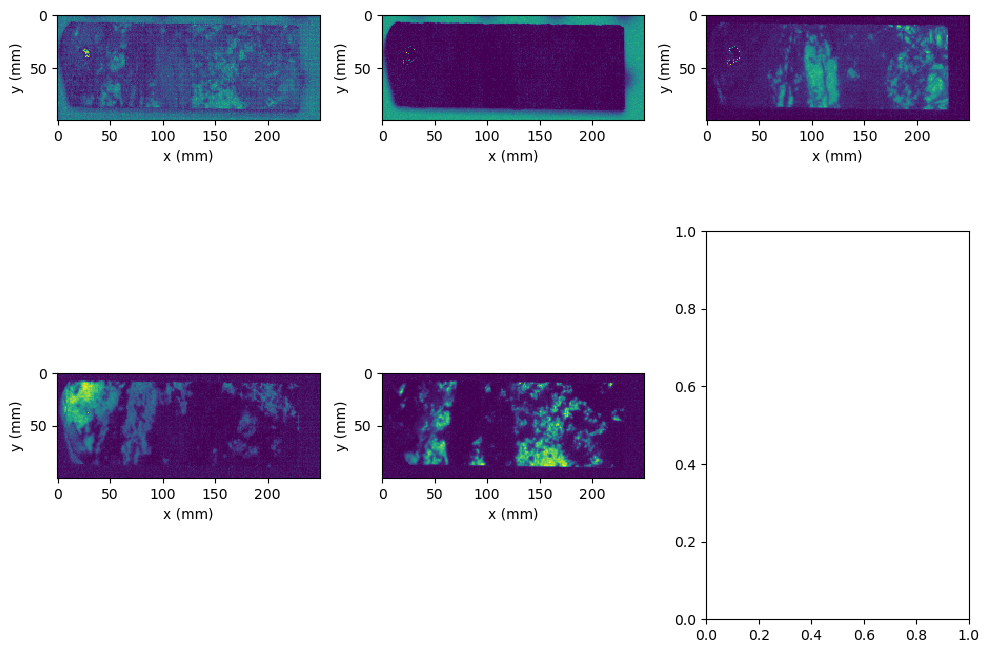

In [47]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
a=kmeans.fit_predict(mask_min_max)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

Não deteta Petalite

## Aplicar thresholds aos mapas antes da classificação

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


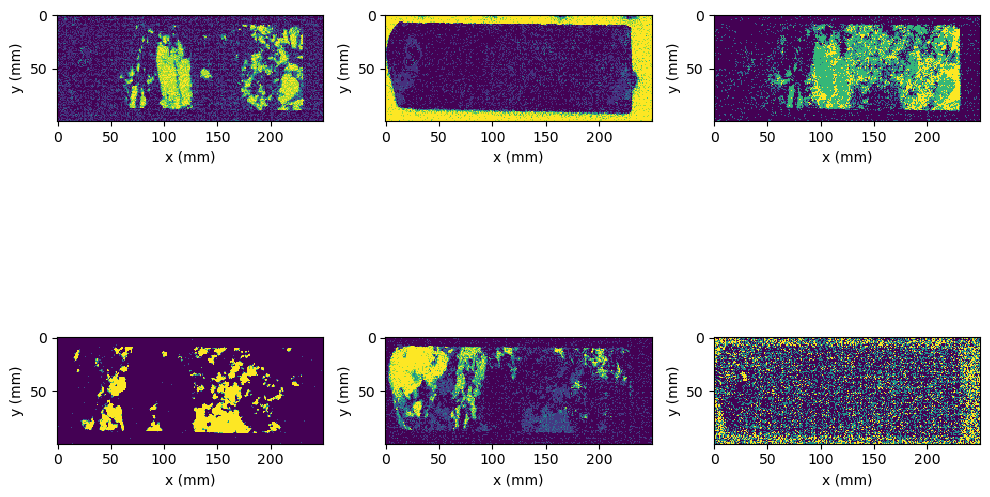

In [48]:
from skimage.filters import threshold_otsu
import cv2
thresholds=np.array([threshold_otsu(mask_min_max[i]) for i in range(mask_min_max.shape[0])])

maps_thres=[]
for i in range(mask_min_max.shape[0]):
    c_mask=np.zeros(mask_min_max.shape[1])
    for j in range(mask_min_max.shape[1]):
        if mask_min_max[i][j]>thresholds[i]:
            c_mask[j]=1
    maps_thres.append(c_mask)
maps_thres=np.array(maps_thres)  

kmeans = sklearn.cluster.KMeans(n_clusters = 6,random_state=0)
a=kmeans.fit_predict(maps_thres)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()


Semelhante ao resultado que se obtinha com a entropia mas com um cluster de ruido

# 6. Outros Testes

## Decomposição PCA dos dados: para ver se dava os minerais

100%|██████████| 1024/1024 [00:00<00:00, 1239.77it/s]


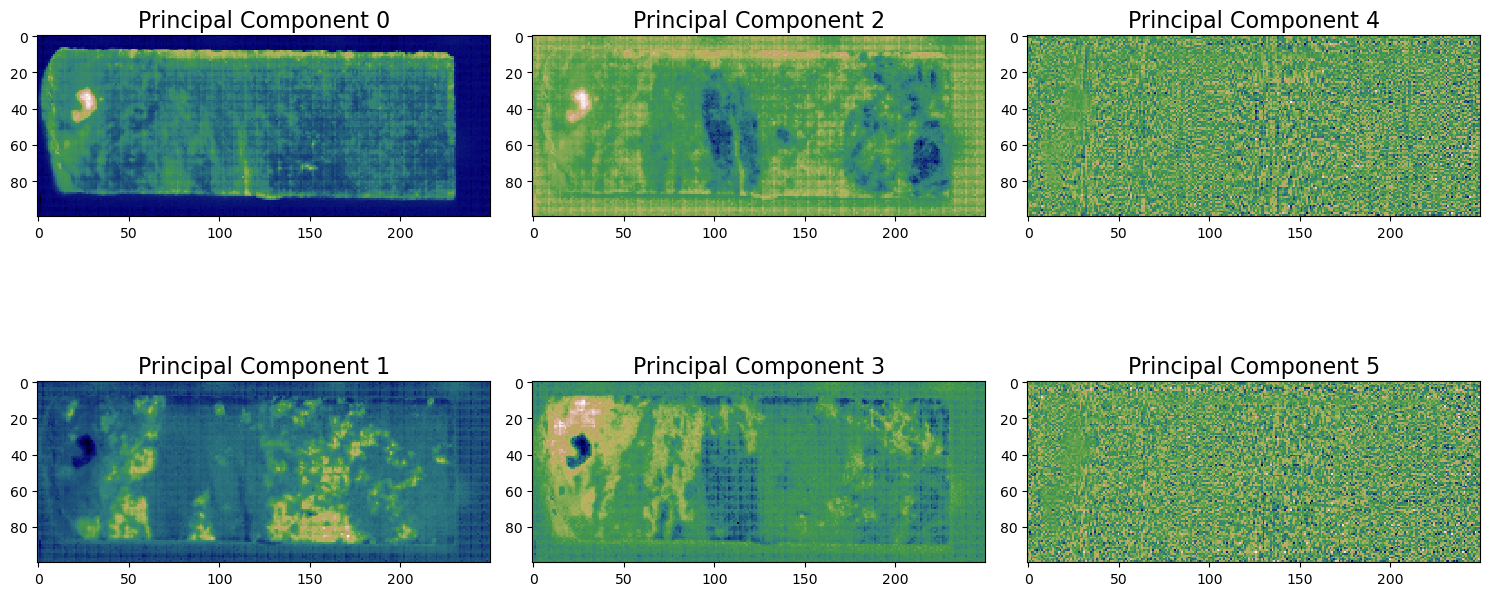

In [49]:
spectrum=pro_data

spe = spectrum.reshape(spectrum.shape[0]*spectrum.shape[1], -1)
norm = np.array([gaussian_filter(spe[i, :]/np.sum(spe[i, :]), sigma = 0) for i in range(0, spe.shape[0])]).reshape(spectrum.shape)

norm_for_pca = norm.reshape(norm.shape[0]*norm.shape[1], -1)

s = norm.min()
b = norm.max()


scaled_pro = np.array([(norm[:, :, wv] - s)/(b - s) 
                       for wv in tqdm(range(norm.shape[-1]))])

scaled_for_pca = scaled_pro.reshape(scaled_pro.shape[0], -1).T

model_basis = sklearn.decomposition.PCA(n_components = 6)
model_basis.fit(scaled_for_pca)

principal_components = model_basis.fit_transform(scaled_for_pca)
weigths = model_basis.components_
mu = np.mean(scaled_for_pca, axis = 0)

principal_images = principal_components.reshape(spectrum.shape[0], spectrum.shape[1], principal_components.shape[-1])

fig, ax = subplots(2, 3, figsize = (15, 8))

h, v = 0, 0

for i in range(principal_components.shape[-1]):
    axs = ax[h, v]
    axs.imshow(principal_images[:, :, i].T, cmap = 'gist_earth', interpolation = 'nearest')
    axs.set_title(f'Principal Component {i}', fontsize = 16)
    axs.grid(False)
    
    h += 1
    if h == 2:
        v += 1
        h = 0

fig.tight_layout()
